# Árbol de decisión P1

* [Descripcion general del notebook](#descripcion-general-del-notebook)  
* [Carga y Preprocesamiento de los Datos](#carga-y-preprocesamiento-de-los-datos)
* [Seleccion y transformacion de variables](#seleccion-y-transformacion-de-variables)
* [Entrenamiento de los modelos](#entrenamiento-de-los-modelos)
* [Evaluacion del modelo](#evaluacion-del-modelo)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import random
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import mlflow
import random

In [4]:
np.random.seed(42)
random.seed(42)

In [2]:
ruta_mlflow = os.path.abspath(os.path.join("..", "..", "..", "mlruns"))

# Configurar MLflow para guardar los modelos en esa ruta
mlflow.set_tracking_uri(f"file:///{ruta_mlflow}")

print("MLflow tracking URI:", mlflow.get_tracking_uri())  

MLflow tracking URI: file:///c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\mlruns


In [5]:
mlflow.set_experiment("Modelos datos de pelas-P1 con DecisionTree, datos finales")

2025/03/26 11:23:18 INFO mlflow.tracking.fluent: Experiment with name 'Modelos datos de pelas-P1 con DecisionTree, datos finales' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:\\Users\\mattu\\OneDrive\\Documentos\\GitHub\\c2425-R4\\mlruns/566389620710109100', creation_time=1742984598766, experiment_id='566389620710109100', last_update_time=1742984598766, lifecycle_stage='active', name='Modelos datos de pelas-P1 con DecisionTree, datos finales', tags={}>

### Descripcion general del notebook

En este notebook, se llevará a cabo un análisis utilizando el modelo de Árbol de decisión para abordar el problema de clasificación con las peleas sin ponderar. El propósito principal de este proyecto es identificar las variables más significativas en el conjunto de datos, en lugar de centrarnos exclusivamente en la optimización del rendimiento del modelo. A lo largo del análisis, se seguirá un enfoque de dos fases:

- Modelo inicial sin ajuste de hiperparámetros: En la primera fase, se entrenará un modelo de Árbol de decisión sin ajustar ningún hiperparámetro. Este modelo se utilizará para establecer una línea base y obtener una comprensión inicial de cómo las variables afectan la predicción. En este punto, el modelo funcionará con los valores predeterminados de los hiperparámetros, como la profundidad máxima del árbol y el número de estimadores.

- Ajuste de hiperparámetros: En la segunda fase, se llevará a cabo un ajuste de hiperparámetros mediante técnicas como la búsqueda en cuadrícula o la búsqueda aleatoria. Esto nos permitirá explorar diversas combinaciones de parámetros y observar cómo influyen en la capacidad del modelo para identificar las variables más relevantes. El objetivo aquí es mejorar la interpretación del modelo en lugar de optimizar la precisión en términos absolutos.

Un aspecto clave de este proyecto es el desbalance de clases en el conjunto de datos. Dado que las clases no están equilibradas, se utilizará el F1 score como la métrica principal para evaluar el rendimiento del modelo en lugar de la precisión (accuracy). El F1 score, que es la media armónica entre la precisión y la sensibilidad, es particularmente útil en situaciones de desbalance de clases porque tiene en cuenta tanto los falsos positivos como los falsos negativos, ofreciendo una evaluación más equilibrada de la capacidad del modelo para predecir correctamente las clases minoritarias.

El análisis realizado en este notebook no tiene como objetivo final alcanzar un alto *accuracy*, sino más bien entender las dinámicas de las variables y su impacto en el modelo. Al identificar las características más importantes, se puede obtener una visión más clara de qué factores están influyendo en la clasificación, lo que puede ser útil para futuras investigaciones o para mejorar modelos más complejos.

### Carga y Preprocesamiento de los Datos

En esta celda se cargan los conjuntos de datos de entrenamiento y prueba, que están almacenados en formato Parquet. Para ello, se utilizan las rutas relativas para acceder a los archivos en el sistema de archivos. Posteriormente, se eliminan las columnas irrelevantes para el análisis, como las relacionadas con la fecha, categoría, métodos de pelea y otros atributos específicos de los peleadores, como los nombres de los peleadores y el título de la pelea. El objetivo es reducir la complejidad de los datos y enfocarse solo en las características relevantes para el modelo, mejorando así el desempeño y la interpretabilidad del modelo posterior.

In [6]:
ruta_train = os.path.join("..","..","..", "data", "P1","train.parquet")
train = pd.read_parquet(ruta_train) 
train = train.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

ruta_test = os.path.join("..","..","..", "data", "P1","test.parquet")
test = pd.read_parquet(ruta_test) 
test = test.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

**División de las Características y la Variable Objetivo**

En esta celda, se separan las características (features) y la variable objetivo (target) en los conjuntos de datos de entrenamiento y prueba. La columna "WINNER", que representa la clase a predecir, se extrae y se asigna a las variables y_train y y_test. El resto de las columnas se asignan a X_train y X_test, que son las matrices de características para entrenar y evaluar el modelo. Este paso es fundamental para preparar los datos para el entrenamiento del modelo de clasificación.

In [7]:
X_train = train.drop(columns=["WINNER"])
y_train = train["WINNER"]

X_test = test.drop(columns=["WINNER"])
y_test = test["WINNER"]

En esta celda, se verifica la distribución de clases en los conjuntos de datos de entrenamiento y prueba. Para ello, se utiliza el método value_counts() de Pandas, que muestra la cantidad de instancias que corresponden a cada clase en cada uno de los conjuntos. Este análisis es crucial para identificar si las clases están desbalanceadas, lo cual puede afectar el rendimiento del modelo, especialmente si se usan métricas como la precisión (accuracy). En este caso, la variable de interés es "WINNER", que indica si el Peleador A o el Peleador B ha ganado la pelea. El objetivo de esta celda es evaluar si el modelo debe enfrentarse a un desbalance de clases y, en caso afirmativo, considerar estrategias para abordarlo, como ajustar el peso de las clases o aplicar técnicas de re-muestreo.

In [8]:
print("Distribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts())

print("\nDistribución de clases en el conjunto de prueba:")
print(y_test.value_counts())

Distribución de clases en el conjunto de entrenamiento:
WINNER
False    2691
True     2040
Name: count, dtype: int64

Distribución de clases en el conjunto de prueba:
WINNER
False    1179
True      849
Name: count, dtype: int64


Los resultados muestran un desbalance moderado en las clases de ambos conjuntos de datos. En el conjunto de entrenamiento, la clase "Peleador A gana" (False) representa aproximadamente el 56.9%, mientras que la clase "Peleador B gana" (True) tiene un 43.1%. En el conjunto de prueba, el patrón es similar, con la clase "Peleador A gana" (False) ocupando el 58.1% y la clase "Peleador B gana" (True) el 41.9%. Este desbalance puede influir en el rendimiento del modelo, favoreciendo a la clase mayoritaria y dificultando la predicción precisa de la clase minoritaria. Para abordar este desbalance, sería útil utilizar métricas como el F1-score o ajustar los pesos de las clases, mejorando así la capacidad del modelo para predecir ambas clases de manera más equilibrada.

### Seleccion y Transformacion de Variables

En esta sección no se realiza una selección manual de variables ni una transformación previa de los datos, ya que el modelo elegido, un árbol de decisión, maneja automáticamente ambos procesos. Los árboles de decisión seleccionan las variables más relevantes dividiendo el espacio de decisión en función de la reducción de impureza, por lo que no es necesario eliminar características irrelevantes manualmente. Además, no requieren normalización ni estandarización de las variables, ya que no dependen de la escala de los datos. Esto simplifica el preprocesamiento y permite que el modelo aprenda directamente de las características en su forma original.

### Entrenamiento de los modelos

**Entrenamiento del Árbol de Decisión Primitivo con Profundidad Limitada**

En esta sección, se entrena un modelo de árbol de decisión básico utilizando el parámetro max_depth=5 para limitar la profundidad máxima del árbol. Este modelo se entrena sin realizar ajustes adicionales de hiperparámetros, lo que nos permite obtener una referencia inicial del rendimiento del modelo. El objetivo es observar cómo se comporta el modelo con los datos de entrenamiento y, posteriormente, evaluar su desempeño en los conjuntos de validación y prueba utilizando el F1-score como métrica principal, dado que las clases están desbalanceadas. Este paso proporciona una base para comparar con los resultados obtenidos tras realizar ajustes más finos en los hiperparámetros.

Además, se muestran los reportes de clasificación para ambos conjuntos (validación y prueba), así como una visualización del árbol de decisión entrenado, lo que permite comprender las reglas y decisiones tomadas por el modelo.

In [9]:
###### ARBOL DE DECISION PRIMITIVO CON LIMITACION DE LA PROFUNDIDAD #####

clf = DecisionTreeClassifier(random_state=42, max_depth=5)  # Ajusta el valor de max_depth según sea necesario
clf=clf.fit(X_train, y_train)

# Evaluar en validación
y_train_pred = clf.predict(X_train)
f1_val = f1_score(y_train, y_train_pred)
print(f'F1-score en train: {f1_val:.4f}')

print("\nClasificación (Train):")
print(classification_report(y_train, y_train_pred))

# Evaluar en test
y_test_pred = clf.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)
print(f'F1-score en test: {f1_test:.4f}')

print("\nClasificación (Test):")
print(classification_report(y_test, y_test_pred))


F1-score en train: 0.8158

Clasificación (Train):
              precision    recall  f1-score   support

       False       0.84      0.90      0.87      2691
        True       0.86      0.78      0.82      2040

    accuracy                           0.85      4731
   macro avg       0.85      0.84      0.84      4731
weighted avg       0.85      0.85      0.85      4731

F1-score en test: 0.7635

Clasificación (Test):
              precision    recall  f1-score   support

       False       0.82      0.87      0.84      1179
        True       0.80      0.73      0.76       849

    accuracy                           0.81      2028
   macro avg       0.81      0.80      0.80      2028
weighted avg       0.81      0.81      0.81      2028



Los resultados obtenidos con este primer modelo sin ajustes de hiperparámetros son bastante sólidos. Aunque no hemos realizado optimización alguna, la precisión es relativamente buena, lo que indica que el árbol de decisión, incluso en su forma básica, es capaz de realizar predicciones de manera razonablemente efectiva. Este desempeño inicial nos sirve como una referencia para evaluar las mejoras que alcanzaremos mediante el ajuste de los hiperparámetros. A medida que optimicemos el modelo, podremos medir de manera más precisa el impacto de estos cambios en la capacidad predictiva.

En esta sección, se obtiene la importancia de cada característica (o variable) en el árbol de decisión entrenado, utilizando el atributo feature_importances_. Luego, se crea un DataFrame que almacena las características junto con sus respectivas importancias, y se ordena en función de la relevancia de cada variable, de mayor a menor. El objetivo de este paso es identificar las variables que tienen un mayor impacto en la toma de decisiones del modelo.

C:\Users\mattu\AppData\Local\Temp\ipykernel_138344\953890896.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Característica', data=feature_importance_df, palette='viridis')


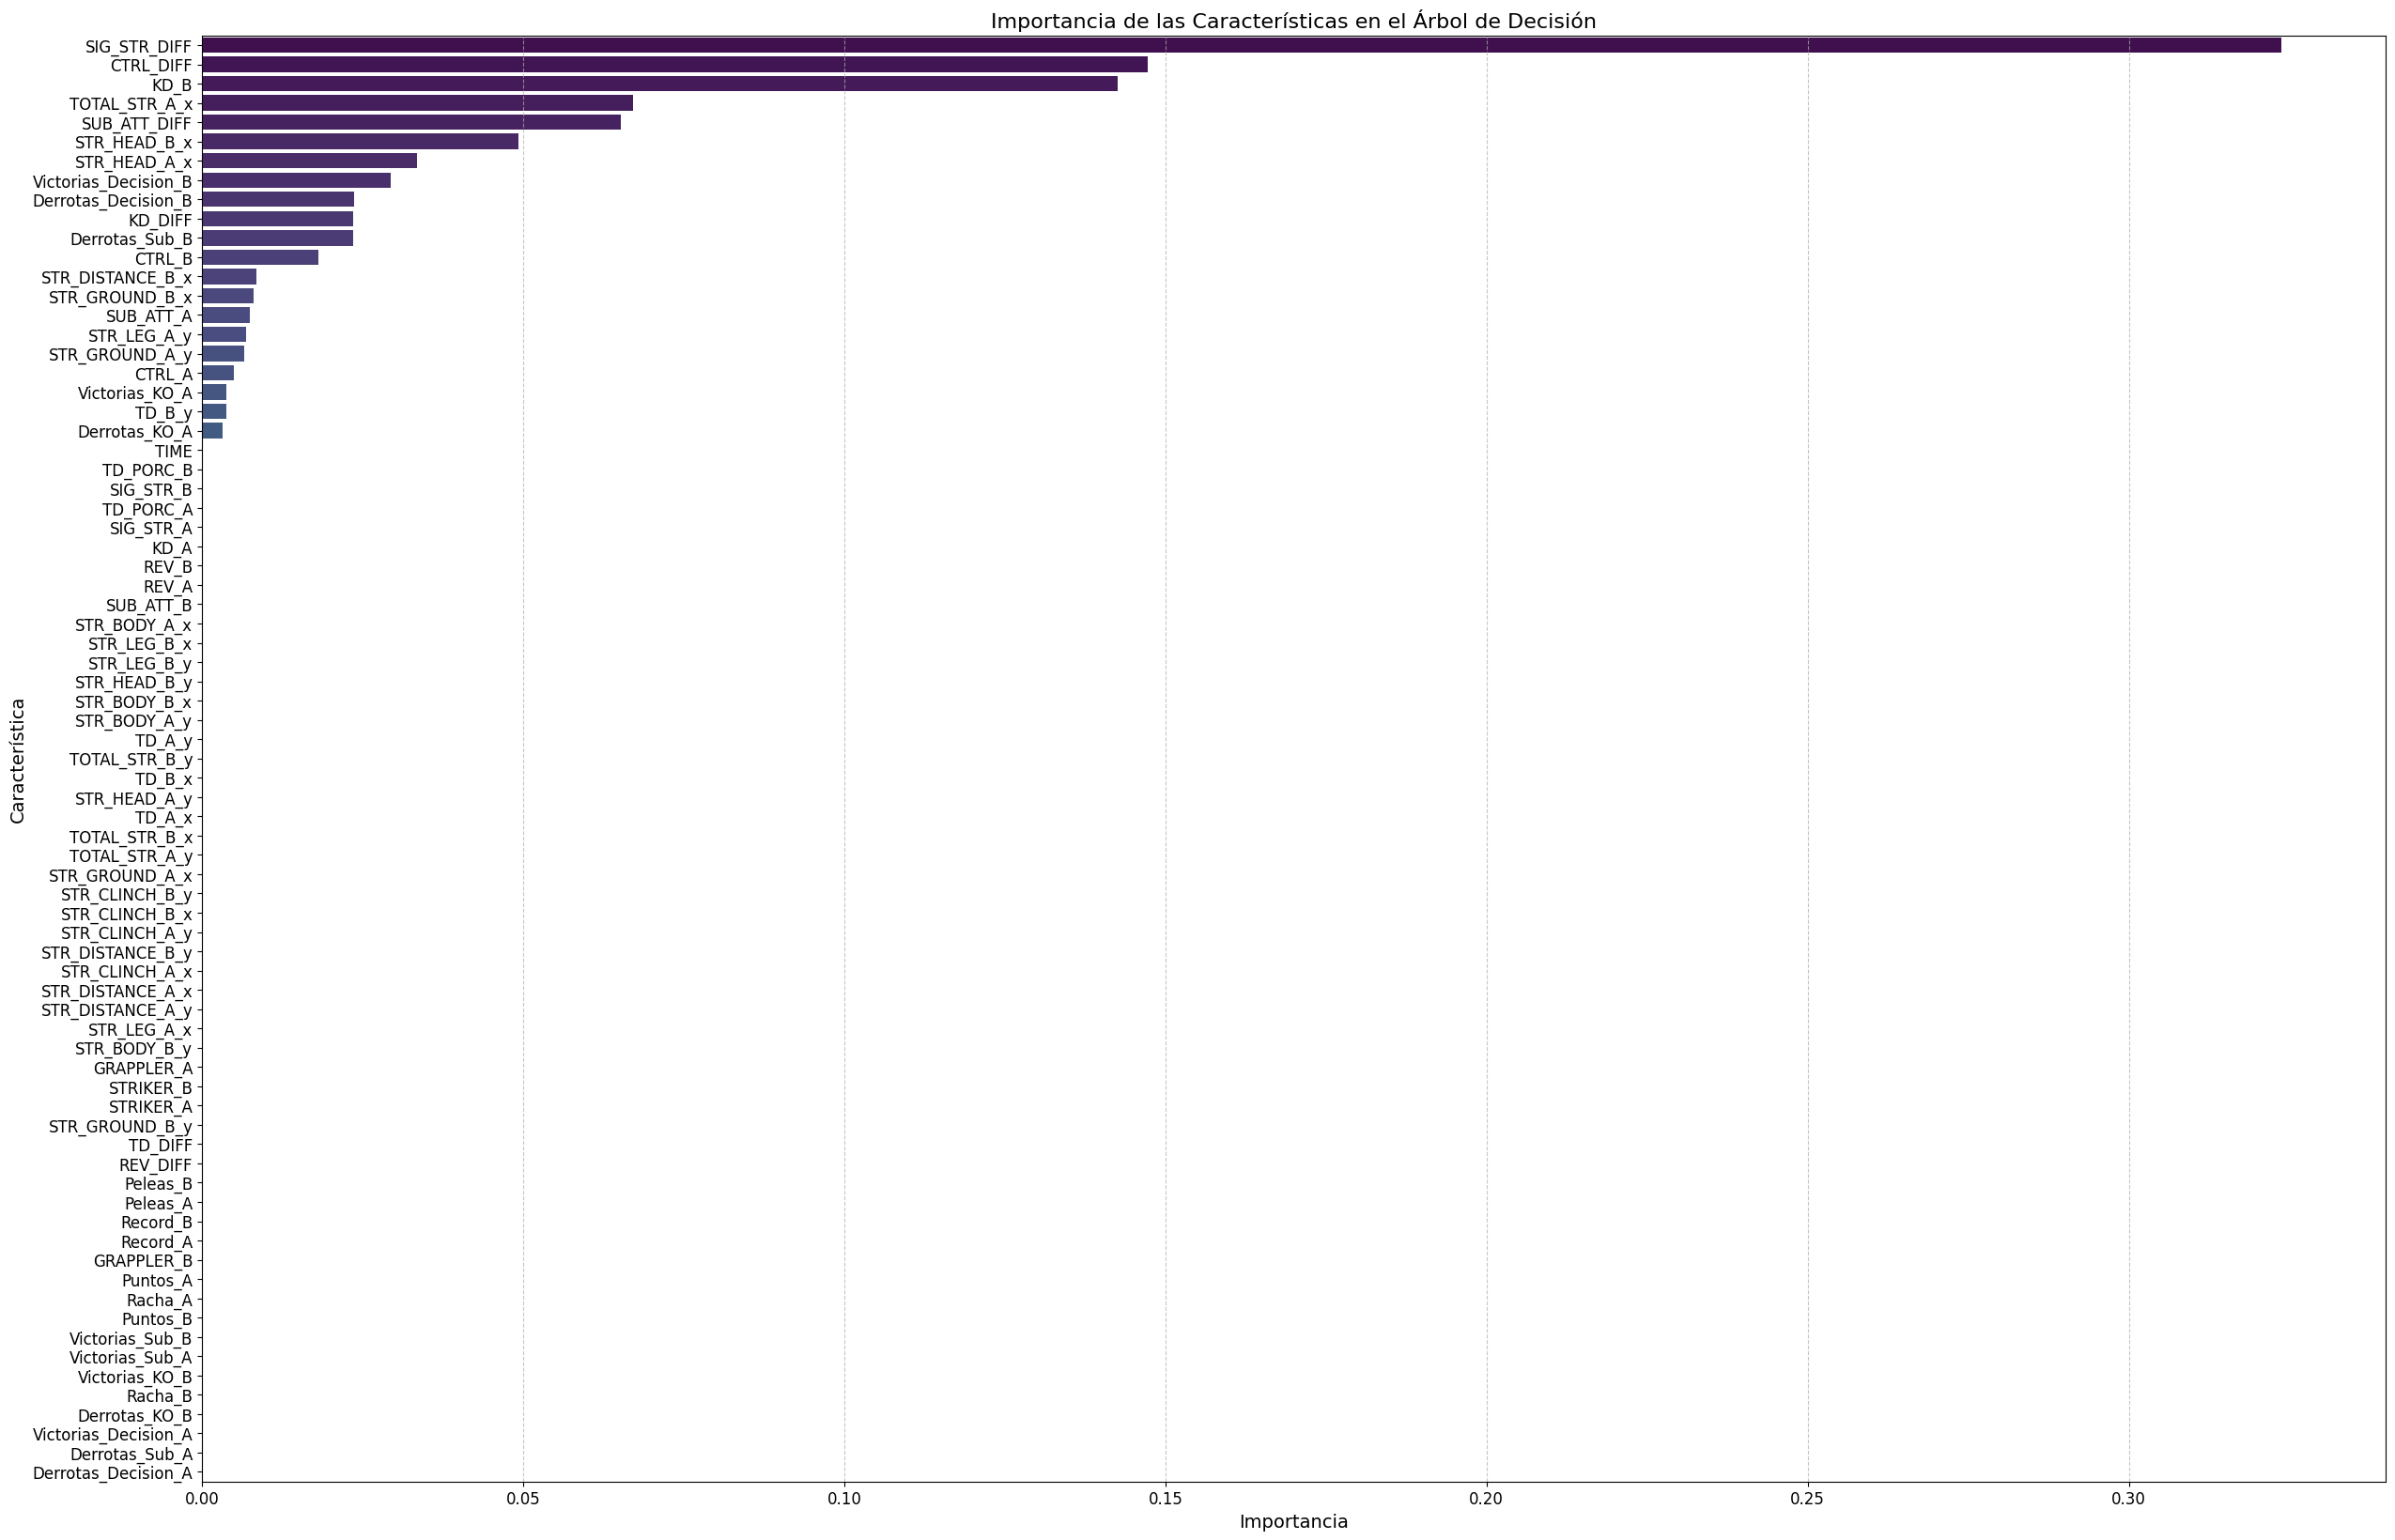

In [10]:
feature_importance = clf.feature_importances_

feature_importance_df = pd.DataFrame({'Característica': X_train.columns, 'Importancia': feature_importance})

feature_importance_df = feature_importance_df.sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(30, 20)) 
sns.barplot(x='Importancia', y='Característica', data=feature_importance_df, palette='viridis')

plt.xlabel('Importancia', fontsize=14)
plt.ylabel('Característica', fontsize=14)
plt.title('Importancia de las Características en el Árbol de Decisión', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()


En el gráfico de barras se puede observar que el modelo ha asignado una importancia destacada a un número reducido de variables. Esto se debe a la profundidad limitada que hemos establecido para el árbol de decisión, lo que restringe su capacidad de capturar relaciones más complejas entre las características. Al limitar la profundidad del árbol, se evita el sobreajuste, pero también se reduce la cantidad de variables que el modelo puede considerar como relevantes. Este comportamiento resalta la necesidad de experimentar con diferentes profundidades en el árbol para evaluar cómo afecta la importancia de las características y el rendimiento general del modelo.

**Búsqueda de los Mejores Hiperparámetros con GridSearchCV**

En esta sección, realizamos una búsqueda exhaustiva de los mejores hiperparámetros para el modelo de árbol de decisión utilizando GridSearchCV. Definimos una amplia gama de hiperparámetros en el diccionario param_grid, que incluye opciones para la profundidad máxima del árbol, el número mínimo de muestras para dividir un nodo, el criterio de división, y otros aspectos que afectan la estructura del árbol. Usamos validación cruzada con 5 pliegues y el F1-score como métrica de evaluación debido al desbalance de clases en el problema.

Una vez realizado el ajuste, se selecciona el modelo con los mejores hiperparámetros encontrados. A continuación, evaluamos el rendimiento del modelo en el conjunto de prueba, calculando el F1-score. Finalmente, se muestran los reportes de clasificación y se visualiza el árbol de decisión resultante, lo que permite analizar cómo las características influyen en las decisiones del modelo con los parámetros óptimos.

In [11]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

clf = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros: {grid_search.best_params_}")

grid_model = grid_search.best_estimator_

y_train_pred = grid_model.predict(X_train)
f1_val = f1_score(y_train, y_train_pred)
print(f'F1-score en entrenamiento: {f1_val:.4f}')

y_test_pred = grid_model.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)
print(f'F1-score en test: {f1_test:.4f}')

print("\nReporte de clasificación (Train):")
print(classification_report(y_train, y_train_pred))

print("\nReporte de clasificación (Test):")
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
F1-score en entrenamiento: 0.9288
F1-score en test: 0.8091

Reporte de clasificación (Train):
              precision    recall  f1-score   support

       False       0.94      0.96      0.95      2691
        True       0.94      0.91      0.93      2040

    accuracy                           0.94      4731
   macro avg       0.94      0.94      0.94      4731
weighted avg       0.94      0.94      0.94      4731


Reporte de clasificación (Test):
              precision    recall  f1-score   support

       False       0.86      0.88      0.87      1179
        True       0.82      0.80      0.81       849

    accuracy                           0.84      2028
   macro avg       0.84      0.84      0.84      2028
weighted avg       0.84      0.84      0.84      2028



In [12]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="Modelo usando GridSearch"):

    # Guardar modelo en MLflow
    mlflow.log_param("mejores_parametros", grid_search.best_params_)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_test_pred))
    mlflow.log_metric("f1_macro", f1_test)

    print("Modelo guardado en MLflow")

Modelo guardado en MLflow


Después de realizar la selección de los mejores hiperparámetros mediante GridSearchCV, al evaluar el modelo optimizado, observamos una mejora en los resultados en comparación con el modelo inicial. Sin embargo, aunque el rendimiento ha mejorado, existen otros modelos que logran una mayor precisión en la predicción. Esto nos lleva a la conclusión de que, aunque los árboles de decisión son herramientas valiosas para identificar las características más importantes, no siempre son los mejores modelos en términos de precisión predictiva. A pesar de su capacidad para interpretar y visualizar las decisiones, su rendimiento puede verse limitado en comparación con otros algoritmos más complejos o especializados.

**Búsqueda de los Mejores Hiperparámetros con RandomizedSearchCV**

En esta sección, realizamos una búsqueda aleatoria de los mejores hiperparámetros para el modelo de árbol de decisión utilizando RandomizedSearchCV. A diferencia de GridSearchCV, esta técnica explora aleatoriamente el espacio de hiperparámetros, lo que permite probar una mayor variedad de combinaciones sin tener que evaluar exhaustivamente todas las opciones posibles. El espacio de búsqueda está definido en el diccionario param_dist, que incluye distribuciones aleatorias para parámetros como la profundidad máxima del árbol, el número mínimo de muestras para dividir un nodo, el criterio de división y el número máximo de características.

Usamos validación cruzada con 5 pliegues y el F1-score como métrica de evaluación debido al desbalance de clases en el problema. Se realiza un total de 20 combinaciones aleatorias de hiperparámetros para encontrar la mejor configuración. Después de realizar el ajuste, se selecciona el modelo con los mejores hiperparámetros y se evalúa su rendimiento en el conjunto de prueba, calculando el F1-score. Finalmente, se muestran los reportes de clasificación tanto en el conjunto de entrenamiento como en el conjunto de prueba.

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definir el espacio de búsqueda de hiperparámetros con distribuciones aleatorias
param_dist = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

clf = DecisionTreeClassifier(random_state=42)

# RandomizedSearchCV busca aleatoriamente dentro del espacio definido
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=20,  # Número de combinaciones aleatorias a probar
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros: {random_search.best_params_}")

random_model = random_search.best_estimator_

y_train_pred = random_model.predict(X_train)
f1_train = f1_score(y_train, y_train_pred)
print(f'F1-score en entrenamiento: {f1_train:.4f}')

y_test_pred = random_model.predict(X_test)
f1_test = f1_score(y_test, y_test_pred)
print(f'F1-score en test: {f1_test:.4f}')

print("\nReporte de clasificación (Train):")
print(classification_report(y_train, y_train_pred))

print("\nReporte de clasificación (Test):")
print(classification_report(y_test, y_test_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores hiperparámetros: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 13}
F1-score en entrenamiento: 0.9324
F1-score en test: 0.8012

Reporte de clasificación (Train):
              precision    recall  f1-score   support

       False       0.95      0.95      0.95      2691
        True       0.93      0.94      0.93      2040

    accuracy                           0.94      4731
   macro avg       0.94      0.94      0.94      4731
weighted avg       0.94      0.94      0.94      4731


Reporte de clasificación (Test):
              precision    recall  f1-score   support

       False       0.86      0.85      0.85      1179
        True       0.79      0.81      0.80       849

    accuracy                           0.83      2028
   macro avg       0.83      0.83      0.83      2028
weighted avg       0.83      0.83      0.83      2028



In [14]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="Modelo usando RandomizedSearch"):

    # Guardar modelo en MLflow
    mlflow.log_param("mejores_parametros", random_search.best_params_)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_test_pred))
    mlflow.log_metric("f1_macro", f1_test)

    print("Modelo guardado en MLflow")

Modelo guardado en MLflow


En esta celda se recuperan y se almacenan los resultados de los modelos previamente ajustados, **grid_model** y **random_model**, que fueron obtenidos a través de **GridSearchCV** y **RandomizedSearchCV** en celdas anteriores. Se guardan los mejores parámetros encontrados en cada modelo, así como el **F1-score** tanto en el conjunto de entrenamiento como en el conjunto de prueba. Finalmente, se imprimen los resultados para comparar el rendimiento de ambos modelos en términos de **F1-score**.

In [15]:
grid_results = {
    'best_params': grid_model.get_params(),
    'f1_train': f1_score(y_train, grid_model.predict(X_train)),
    'f1_test': f1_score(y_test, grid_model.predict(X_test))
}

random_results = {
    'best_params': random_model.get_params(),
    'f1_train': f1_score(y_train, random_model.predict(X_train)),
    'f1_test': f1_score(y_test, random_model.predict(X_test))
}

# Mostrar los resultados
print("Resultados Grid Search:", grid_results['f1_train'], grid_results['f1_test'])
print("Resultados Randomized Search:", random_results['f1_train'], random_results['f1_test'])


Resultados Grid Search: 0.9287848605577689 0.8090963494913226
Resultados Randomized Search: 0.9323895533317061 0.8011661807580175


Los resultados muestran que el modelo ajustado mediante **Grid Search** tiene un **F1-score** de 0.929 en el conjunto de entrenamiento y 0.809 en el conjunto de prueba. Esto indica un buen ajuste en los datos de entrenamiento, aunque hay una ligera diferencia entre los F1-scores de entrenamiento y prueba, lo que sugiere que el modelo podría estar ajustándose en exceso a los datos de entrenamiento.

Por otro lado, el modelo ajustado con **Randomized Search** presenta un **F1-score** de 0.932 en el conjunto de entrenamiento y 0.801 en el conjunto de prueba. Aunque el **F1-score** en entrenamiento es un poco más alto que el de Grid Search, el rendimiento en el conjunto de prueba es muy similar, lo que sugiere que el modelo tiene una generalización más equilibrada.

En resumen, **Grid Search** tiene un rendimiento ligeramente mejor en el conjunto de entrenamiento, pero **Randomized Search** tiene una generalización más equilibrada en el conjunto de prueba, lo que puede ser preferible para evitar el sobreajuste y mejorar la capacidad del modelo para generalizar a datos no vistos.

En esta celda se comparan las importancias de las características obtenidas a partir de los modelos ajustados mediante **Grid Search** y **Randomized Search**. Primero, se extraen las importancias de las características para ambos modelos utilizando el atributo `feature_importances_`. Luego, se organizan en un DataFrame y se ordenan de mayor a menor importancia. 

A continuación, se crean dos gráficos de barras, uno para cada modelo, para visualizar las características más relevantes según cada estrategia de ajuste de hiperparámetros. Los gráficos se presentan en una sola figura con dos subgráficos (uno para cada modelo), lo que permite comparar visualmente las importancias de las características en ambos enfoques. Finalmente, se ajustan los títulos, etiquetas y estilos de los gráficos para mejorar la legibilidad.

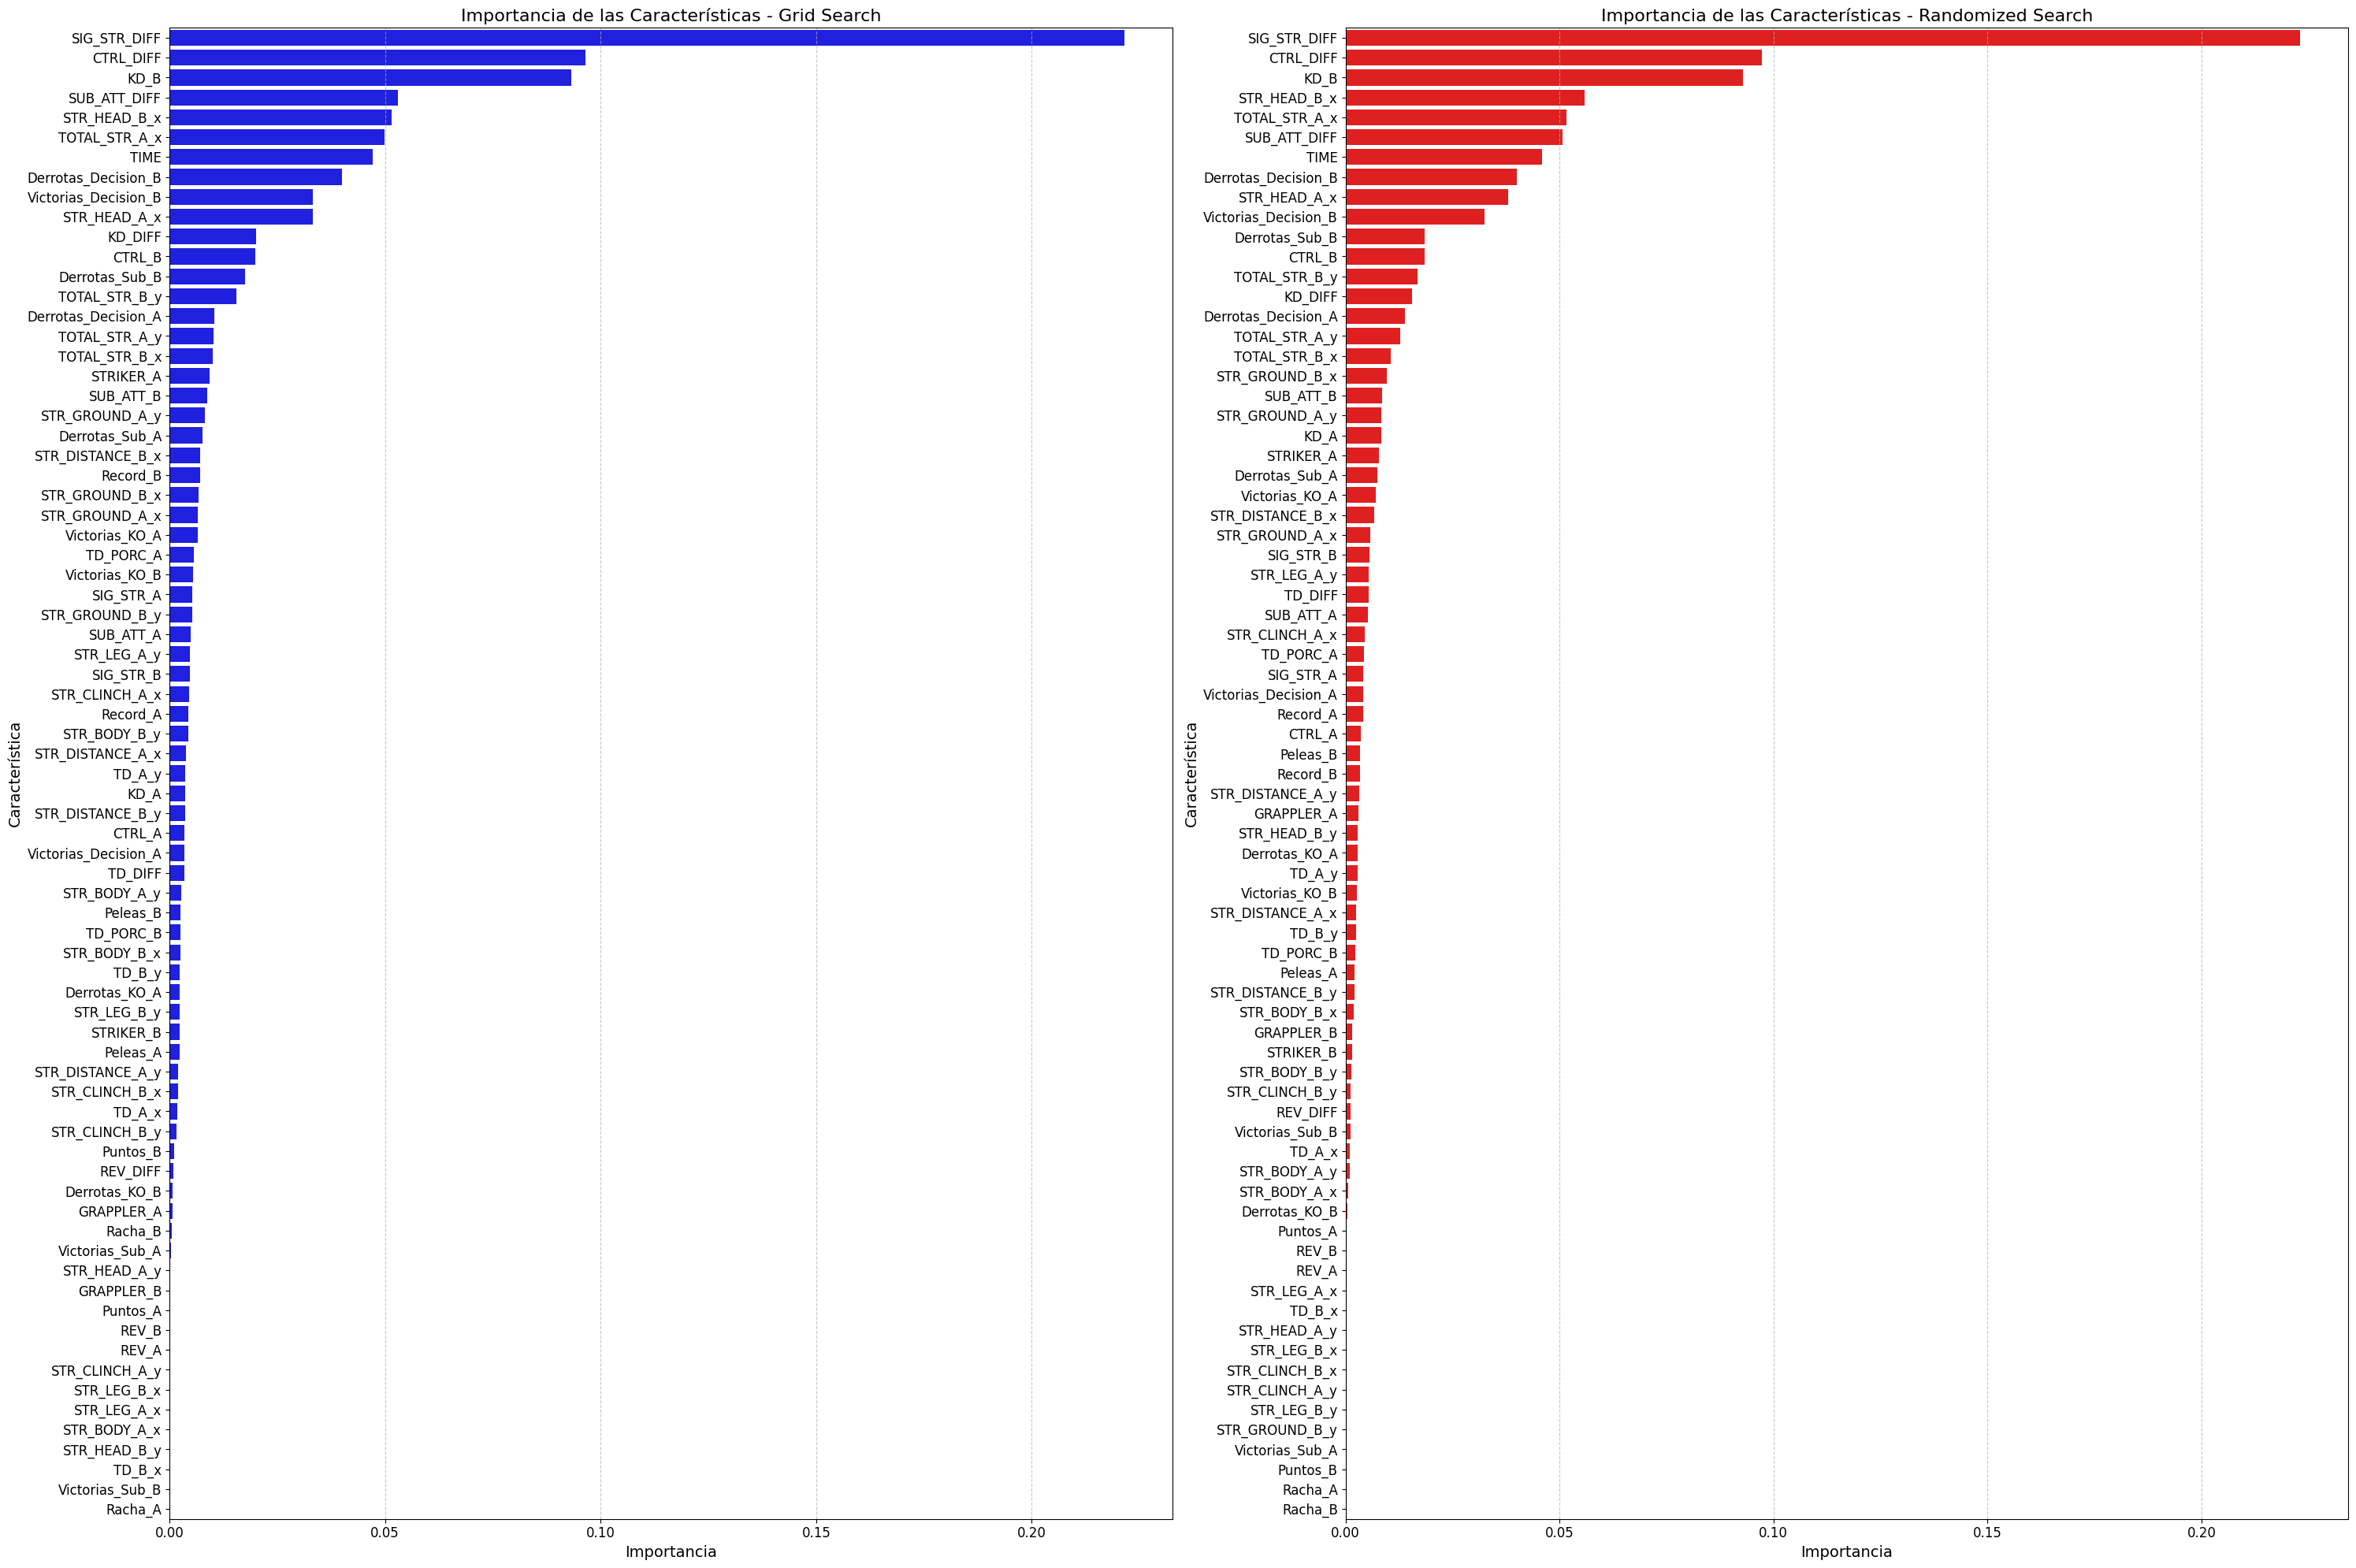

In [16]:
best_model_grid = grid_search.best_estimator_
best_model_random = random_search.best_estimator_

feature_importance_grid = best_model_grid.feature_importances_
feature_importance_df_grid = pd.DataFrame({'Característica': X_train.columns, 'Importancia': feature_importance_grid})

feature_importance_random = best_model_random.feature_importances_
feature_importance_df_random = pd.DataFrame({'Característica': X_train.columns, 'Importancia': feature_importance_random})

feature_importance_df_grid = feature_importance_df_grid.sort_values(by='Importancia', ascending=False)
feature_importance_df_random = feature_importance_df_random.sort_values(by='Importancia', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(30, 20))

# Gráfico para Grid Search
sns.barplot(x='Importancia', y='Característica', data=feature_importance_df_grid, color='blue', ax=axes[0])
axes[0].set_title('Importancia de las Características - Grid Search', fontsize=16)
axes[0].set_xlabel('Importancia', fontsize=14)
axes[0].set_ylabel('Característica', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.7)

# Gráfico para Randomized Search
sns.barplot(x='Importancia', y='Característica', data=feature_importance_df_random, color='red', ax=axes[1])
axes[1].set_title('Importancia de las Características - Randomized Search', fontsize=16)
axes[1].set_xlabel('Importancia', fontsize=14)
axes[1].set_ylabel('Característica', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Después de observar los gráficos, podemos notar que ambos modelos, **Grid Search** y **Randomized Search**, asignan importancia a las mismas tres primeras variables. Sin embargo, a partir de ahí, comienzan a diferir en la distribución de la importancia. **Grid Search** distribuye la relevancia de manera más equitativa entre las siguientes variables, mientras que **Randomized Search** se enfoca más en un conjunto diferente de características, otorgando mayor importancia a algunas variables que el modelo de **Grid Search** no considera tan relevantes. Esto indica que, aunque ambos modelos comparten un enfoque similar en las primeras variables, sus estrategias de selección y ponderación de características se empiezan a diferenciar después de las primeras tres.

### Evaluacion del modelo

**Evaluación del Modelo mediante la Matriz de Confusión**

En esta celda, se realizan las predicciones sobre el conjunto de test utilizando los modelos obtenidos mediante **Grid Search** y **Randomized Search**. Primero, se calcula la matriz de confusión para ambos modelos, lo que permite evaluar el desempeño de cada uno en términos de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos. Luego, se visualizan estas matrices de confusión en gráficos separados, uno para cada modelo. El gráfico de la matriz de confusión de **Grid Search** se representa con el esquema de colores "Blues", mientras que el de **Randomized Search** utiliza "Reds". Estos gráficos proporcionan una representación visual clara de las diferencias en las predicciones de ambos modelos, facilitando la comparación de su rendimiento.

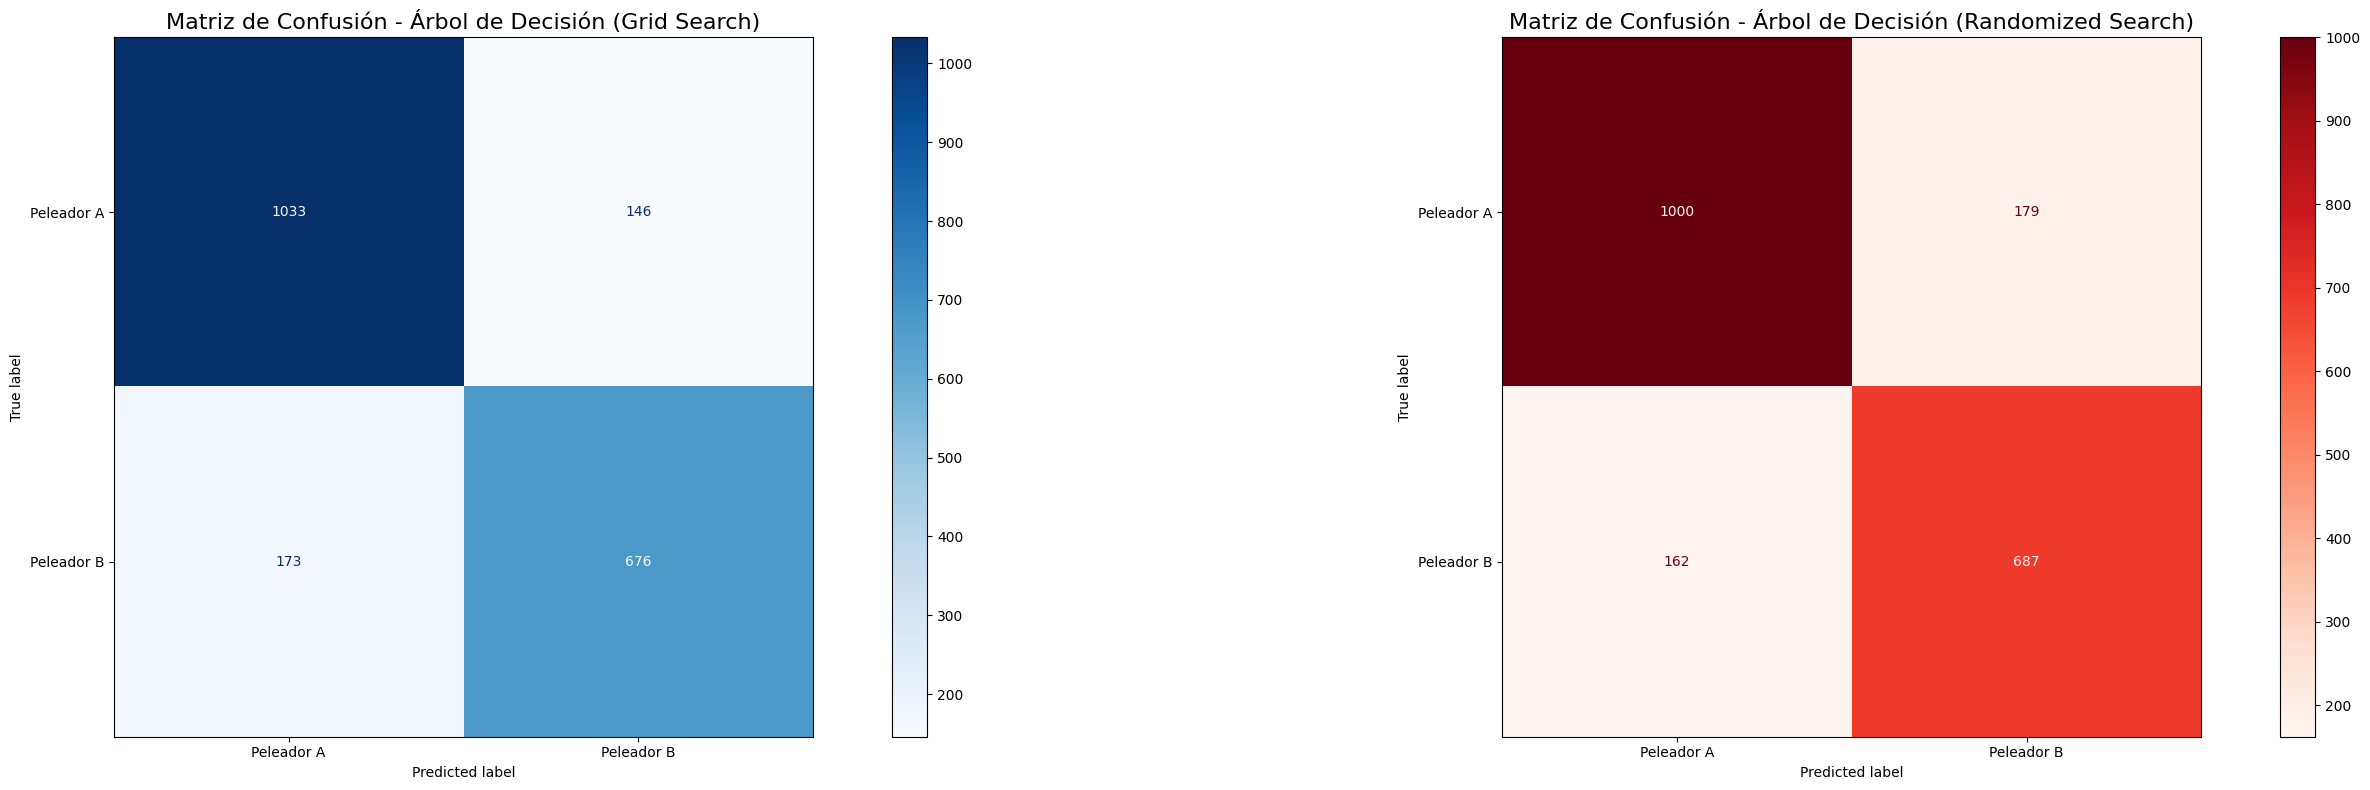

In [17]:
best_model_grid = grid_search.best_estimator_
best_model_random = random_search.best_estimator_

y_pred_grid = best_model_grid.predict(X_test)
cm_grid = confusion_matrix(y_test, y_pred_grid)

y_pred_random = best_model_random.predict(X_test)
cm_random = confusion_matrix(y_test, y_pred_random)

fig, axes = plt.subplots(1, 2, figsize=(30, 8))

disp_grid = ConfusionMatrixDisplay(confusion_matrix=cm_grid, display_labels=["Peleador A", "Peleador B"])
disp_grid.plot(cmap='Blues', values_format='d', ax=axes[0])
axes[0].set_title('Matriz de Confusión - Árbol de Decisión (Grid Search)', fontsize=16)

disp_random = ConfusionMatrixDisplay(confusion_matrix=cm_random, display_labels=["Peleador A", "Peleador B"])
disp_random.plot(cmap='Reds', values_format='d', ax=axes[1])
axes[1].set_title('Matriz de Confusión - Árbol de Decisión (Randomized Search)', fontsize=16)

plt.tight_layout()
plt.show()


Los resultados muestran que el modelo ajustado mediante **Grid Search** tiene una matriz de confusión con 1033 verdaderos negativos, 146 falsos positivos, 173 falsos negativos y 676 verdaderos positivos. La precisión es bastante alta en ambos casos, pero con una ligera tendencia a clasificar erróneamente más falsos positivos en comparación con falsos negativos.

Por otro lado, el modelo ajustado con **Randomized Search** tiene una matriz de confusión con 1000 verdaderos negativos, 179 falsos positivos, 162 falsos negativos y 687 verdaderos positivos. Aunque el número de falsos positivos es ligeramente mayor que en el modelo de Grid Search, la cantidad de falsos negativos es algo menor, lo que podría indicar un mejor rendimiento en la identificación de la clase positiva (Peleador B).

En resumen, ambos modelos muestran un buen desempeño, pero el modelo de **Randomized Search** tiene una ligera ventaja en términos de identificación de la clase positiva, mientras que el modelo de **Grid Search** presenta una menor tasa de falsos positivos. Sin embargo, la diferencia no es muy grande, lo que sugiere que ambos enfoques ofrecen un rendimiento bastante equilibrado.

**Evaluación del Modelo con la Curva ROC**

En esta celda, se calculan las probabilidades de predicción para **Peleador B** en ambos modelos utilizando el método `predict_proba()`. Luego, se calculan las curvas ROC para cada modelo (Grid Search y Randomized Search) mediante la función `roc_curve()` y se obtiene el valor del AUC (Área Bajo la Curva) para cada una utilizando la función `auc()`. Finalmente, se grafican ambas curvas ROC en un solo gráfico, con una línea gris representando la línea de no discriminación (un modelo aleatorio). La curva ROC para **Grid Search** se traza en azul, mientras que la de **Randomized Search** se traza en rojo. El gráfico permite comparar visualmente el rendimiento de ambos modelos, donde un AUC más cercano a 1 indica mejor desempeño.

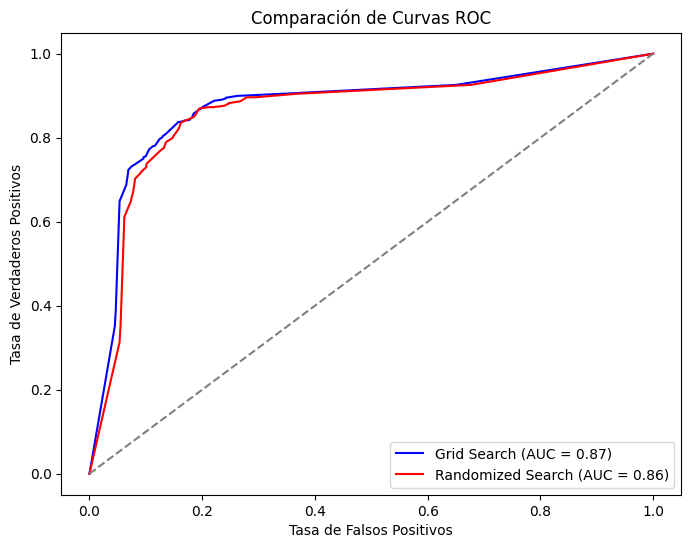

In [18]:
best_model_grid = grid_search.best_estimator_
best_model_random = random_search.best_estimator_

y_probs_grid = best_model_grid.predict_proba(X_test)[:, 1]
y_probs_random = best_model_random.predict_proba(X_test)[:, 1]

fpr_grid, tpr_grid, _ = roc_curve(y_test, y_probs_grid)
roc_auc_grid = auc(fpr_grid, tpr_grid)

fpr_random, tpr_random, _ = roc_curve(y_test, y_probs_random)
roc_auc_random = auc(fpr_random, tpr_random)

plt.figure(figsize=(8, 6))
plt.plot(fpr_grid, tpr_grid, color='blue', label=f'Grid Search (AUC = {roc_auc_grid:.2f})')
plt.plot(fpr_random, tpr_random, color='red', label=f'Randomized Search (AUC = {roc_auc_random:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Comparación de Curvas ROC')
plt.legend(loc='lower right')
plt.show()


Con un AUC de 0.87 para el modelo de **Grid Search** y 0.86 para el modelo de **Randomized Search**, ambos modelos muestran un rendimiento similar en términos de capacidad de clasificación, con el modelo de **Grid Search** ligeramente superior. Aunque la diferencia es pequeña, el modelo de **Grid Search** tiene una ventaja marginal en cuanto a su capacidad para distinguir entre las clases, ya que su AUC es más alto. Sin embargo, ambos modelos presentan un AUC por encima de 0.8, lo que indica que ambos tienen una buena capacidad discriminativa y un rendimiento adecuado para este conjunto de datos.

**Evaluación del Modelo con un Ejemplo Aleatorio**

En esta sección, seleccionamos un índice aleatorio del conjunto de prueba para realizar una predicción sobre una pelea específica. A partir de este índice, extraemos las características de la pelea y obtenemos la etiqueta real correspondiente al ganador (Peleador A o Peleador B). A continuación, utilizamos el modelo optimizado para predecir el ganador de la pelea.

Se comparan el ganador real y el ganador predicho por el modelo para analizar cómo se desempeña el modelo en un caso individual. Mostrar este tipo de ejemplos aleatorios permite entender mejor el comportamiento del modelo en situaciones concretas, y proporciona una forma intuitiva de visualizar cómo el modelo toma decisiones.

In [19]:
random_index = random.randint(0, len(X_test) - 1)

pelea_ejemplo = X_test.iloc[random_index:random_index+1]  
pelea_real = y_test.iloc[random_index] 

prediccion = random_model.predict(pelea_ejemplo)[0]  

ganador_real = "Peleador B" if pelea_real else "Peleador A"
ganador_predicho = "Peleador B" if prediccion else "Peleador A"

print("===== PELEA ALEATORIA =====")
print(pelea_ejemplo)  
print("\nGanador Real: ", ganador_real)
print("Predicción del Modelo: ", ganador_predicho)


===== PELEA ALEATORIA =====
      TIME  KD_A  KD_B  SIG_STR_A  SIG_STR_B  TD_PORC_A  TD_PORC_B  SUB_ATT_A  \
1309   300     1     0       0.52        0.6        1.0       0.72          0   

      SUB_ATT_B  REV_A  ...  Victorias_Sub_A  Victorias_Sub_B  \
1309          0      0  ...                0                0   

      Victorias_Decision_A  Victorias_Decision_B  Derrotas_KO_A  \
1309                     2                     0              0   

      Derrotas_KO_B  Derrotas_Sub_A  Derrotas_Sub_B  Derrotas_Decision_A  \
1309              0               0               1                    0   

      Derrotas_Decision_B  
1309                    1  

[1 rows x 75 columns]

Ganador Real:  Peleador A
Predicción del Modelo:  Peleador B
